<h1 style="text-align:center">Introduction to Hyperparameter Tuning </h1>

<div style="text-align:center;"><img src="https://images.unsplash.com/photo-1503792453751-9dffb431aa63?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1636&q=80" /></div>

### About the Notebook:

**In this notebook, I want to address different approaches to hyperparameter tuning using the example of the titanic dataset.**

### About the dataset:

**Context:** 
> The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

**About the Data:**

<ul>
    <li>survival:	Survival</li>
        <ul>
            <li>0 = No</li>
            <li>1 = Yes </li>
        </ul>
    <li>pclass: A proxy for socio-economic status (SES)</li>
        <ul>
            <li>1 = 1st (Upper)</li>
            <li>2 = 2nd (Middle)</li>
            <li>3 = 3rd (Lower)</li>
        </ul>
    <li>sex: Sex</li>
        <ul>
            <li>0 = male</li>
            <li>1 = female </li>
        </ul>
    <li>age: Age in years. Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5</li>
    <li>sibsp: # of siblings / spouses aboard the Titanic. The dataset defines family relations in this way:</li>
        <ul>
            <li>Sibling = brother, sister, stepbrother, stepsister</li>
            <li>Spouse = husband, wife (mistresses and fiancés were ignored)</li>
        </ul>
    <li>parch: # of parents / children aboard the Titanic. The dataset defines family relations in this way:</li>
        <ul>
            <li>Parent = mother, father</li>
            <li>Child = daughter, son, stepdaughter, stepson</li>
            <li>Some children travelled only with a nanny, therefore parch=0 for them.</li>
        </ul>
    <li>fare: Passenger fare</li>
    <li>embarked: Port of Embarkation</li>
        <ul>
            <li>C = Cherbourg</li>
            <li>Q = Queenstown</li>
            <li>S = Southampton</li>
        </ul>
</ul> 


# Imports

In [1]:
# Data Processing
import numpy as np 
import pandas as pd 


# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Modeling
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Preparing the data

I would like to skip right to the point where we have prepared data without desciption.
I am using the same approach as in this [Kernal](https://www.kaggle.com/dietzschdaniel/my-simplistic-titanic-approach-0-79665).

In [2]:
# Loading the data
df_train = pd.read_csv("/kaggle/input/titanic/train.csv")
df_test = pd.read_csv("/kaggle/input/titanic/test.csv")


# Handling NaN values
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].mean())
df_test['Age'] = df_test['Age'].fillna(df_test['Age'].mean())

df_train['Cabin'] = df_train['Cabin'].fillna("Missing")
df_test['Cabin'] = df_test['Cabin'].fillna("Missing")

df_train = df_train.dropna()

df_test['Fare'] = df_test['Fare'].fillna(df_test['Fare'].mean())

# Cleaning the data
df_train = df_train.drop(columns=['Name'], axis=1)
df_test = df_test.drop(columns=['Name'], axis=1)

sex_mapping = {
    'male': 0,
    'female': 1
}
df_train.loc[:, "Sex"] = df_train['Sex'].map(sex_mapping)
df_test.loc[:, "Sex"] = df_test['Sex'].map(sex_mapping)

df_train = df_train.drop(columns=['Ticket'], axis=1)
df_test = df_test.drop(columns=['Ticket'], axis=1)

df_train = df_train.drop(columns=['Cabin'], axis=1)
df_test = df_test.drop(columns=['Cabin'], axis=1)

df_train = pd.get_dummies(df_train, prefix_sep="__",
                              columns=['Embarked'])
df_test = pd.get_dummies(df_test, prefix_sep="__",
                              columns=['Embarked'])

Our data now looks as follows:

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked__C,Embarked__Q,Embarked__S
0,1,0,3,0,22.0,1,0,7.2500,0,0,1
1,2,1,1,1,38.0,1,0,71.2833,1,0,0
2,3,1,3,1,26.0,0,0,7.9250,0,0,1
3,4,1,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,0,35.0,0,0,8.0500,0,0,1


In [4]:
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked__C,Embarked__Q,Embarked__S
0,892,3,0,34.5,0,0,7.8292,0,1,0
1,893,3,1,47.0,1,0,7.0000,0,0,1
2,894,2,0,62.0,0,0,9.6875,0,1,0
3,895,3,0,27.0,0,0,8.6625,0,0,1
4,896,3,1,22.0,1,1,12.2875,0,0,1


# Hyperparameter Tuning

### Preparing the data for Modeling

In [5]:
# Everything except the target variable
X = df_train.drop("Survived", axis=1)

# Target variable
y = df_train['Survived'].values

In [6]:
# Random seed for reproducibility
np.random.seed(42)

# Splitting the data into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Later I will be using `KNeighborsClassifier()` and `RandomForestClassifier()`.
Let's check out the scores of `KNeighborsClassifier()` and `RandomForestClassifier()` ***without*** hyperparameter tuning:

In [7]:
# Setting up KNeighborsClassifier()
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.6179775280898876

In [8]:
# Setting up RandomForestClassifier()
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.7865168539325843

## Tuning hyperparameters by hand

One way is of course to tune the hyperparameters by hand.

In this example, we tune the hyperparameter `n_neighbors` of the `KNeighborsClassifier()` by looping through different `n_neighbors` values and comparing their score.

In [9]:
# List of train scores
train_scores = []

# List of test scores
test_scores = []

# List of different values for n_neighbors
neighbors = range(1, 51) # 1 to 50

# Setting up the classifier
knn = KNeighborsClassifier()

# Loop through different neighbors values
for i in neighbors:
    knn.set_params(n_neighbors = i) # set neighbors value
    
    # Fitting the algorithm
    knn.fit(X_train, y_train)
    
    # Append the training scores
    train_scores.append(knn.score(X_train, y_train))
    
    # Append the test scores
    test_scores.append(knn.score(X_test, y_test))

Let's plot the train and test scores for the different neighbour values:

Maximum KNN score on the test data: 69.66%
Number of Neighbours with Maximum KNN: 29


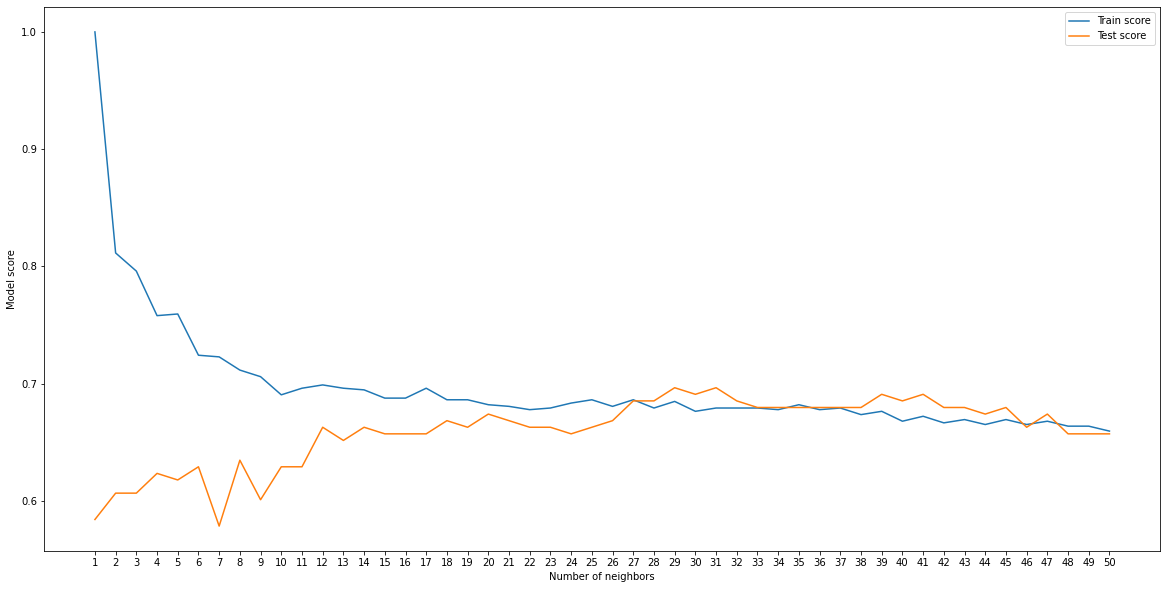

In [10]:
# Plotting the Train and Test scores
plt.figure(figsize=(20,10))
plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores, label="Test score")
plt.xticks(np.arange(1, 51, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()


print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%")
print(f"Number of Neighbours with Maximum KNN: {test_scores.index(max(test_scores)) + 1}")

The Maximum KNN score on the test data is reached with `n_neighbors = 29` with a score of `69.66%`.

## Tuning hyperparameters using ***RandomizedSearchCV()***

`RandomizedSearchCV()` uses a randomized search through hyperparameters.   

In this example we use the `RandomForestClassifier()`.

First, we have to define a dictionary of hyperparameters we would like to check:

In [11]:
# Setting up dictionary with RandomForestClassifier hyperparameters
rfc_rs_grid = {"n_estimators": np.arange(10, 1000, 50),
               "max_depth": [None, 3, 5, 10],
               "min_samples_split": np.arange(2, 20, 2),
               "min_samples_leaf": np.arange(1, 20, 2)}

Now let's set up the hyperparameter search for the `RandomForestClassifier()` using `RandomizedSearchCV()`.

In [12]:
# Import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Setting random seed
np.random.seed(42)

# Setting random hyperparameter search for RandomForestClassifier
rs_rfc = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rfc_rs_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fitting random hyperparameter search model
rs_rfc.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.0min finished


In [13]:
# Finding the best parameters
rs_rfc.best_params_

{'n_estimators': 910,
 'min_samples_split': 18,
 'min_samples_leaf': 1,
 'max_depth': 10}

In [14]:
# Evaluate the model
rs_rfc.score(X_test, y_test)

0.797752808988764

We were able to improve the score!

## Tuning hyperparameters using ***GridSearchCV()***

`GridSearchCV()` uses exhaustive search over specified parameter values for an estimator.  

In this example we use the `RandomForestClassifier()`.

First, we again have to define the dictionary. This time we only use `n_estimators` and `max_depth` since this approach takes a lot of time to compute.

In [15]:
# Setting up dictionary with RandomForestClassifier hyperparameters
rfc_gs_grid = {"n_estimators": np.arange(10, 1010, 100),
               "max_depth": [None, 5, 10]}

In [16]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV


# Setting grid hyperparameter search for RandomForestClassifier
gs_rfc = GridSearchCV(RandomForestClassifier(),
                          param_grid=rfc_gs_grid,
                          cv=5,
                          verbose=True)

# Fitting grid hyperparameter search model
gs_rfc.fit(X_train, y_train);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  3.0min finished


In [17]:
# Finding the best parameters
gs_rfc.best_params_

{'max_depth': 10, 'n_estimators': 110}

In [18]:
# Evaluate the model
gs_rfc.score(X_test, y_test)

0.7865168539325843

In this case we reached the same score as without the hyperparameter tuning. We could try a different dictionary to improve the score. However, due to the long time to compute and since this is just a demonstration, I will leave it like this.

**If you liked this notebook or found it helpful in any way, feel free to leave an upvote - That will keep me motivated :)**

**If you have any suggestions for improvement, leave a comment :)**